In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf
from window_generator import WindowGenerator
from seaborn import violinplot
from sklearn.model_selection import train_test_split

np.set_printoptions(precision = 4)

2023-01-26 08:58:39.492081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def queryRangePostCode(df_power, consumption_range_kwh = 2000, post_code = "81737", rank_range = None) -> pd.DataFrame:
    res = df_power.loc[(df_power.consumption_range_kwh == consumption_range_kwh) & (df_power.post_code == post_code)].copy()
    
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        if rank_range != None:
            res = res.loc[(res["rank"] >= rank_range[0]) & (res["rank"] <= rank_range[1])]

        #Aggregating for mean household prices per day 
        res = res.groupby('valid_range').agg({'price_kwh':'mean'})
    return res

In [4]:
path_clean_power = "./data/master_competitor_market_prices_power.csv"
path_master_market = "./data/master_market.csv"

dtypes = {"date_valid_from": str, "date_valid_to": str, "consumption_range_kwh": np.int32, "price_year_eur": np.float64, "post_code": str, "rank": np.float16}
usecols = [name for name, _ in dtypes.items()]

household = pd.read_csv(path_clean_power, usecols=usecols, dtype = dtypes)
market = pd.read_csv(path_master_market, header = [0], parse_dates=["date"]).drop("Unnamed: 0", axis=1)

market.set_index("date", inplace = True)
market.interpolate(method = "time", axis = 0, inplace = True)
household["date_valid_to"].replace({"9999-12-31": "2022-10-15"}, inplace=True)
household["price_kwh"] = household["price_year_eur"]/household["consumption_range_kwh"]
household["date_valid_from"] = pd.to_datetime(household["date_valid_from"])
household["date_valid_to"] = pd.to_datetime(household["date_valid_to"])
postCodes = household.post_code.unique()
consRanges = household.consumption_range_kwh.unique()

In [5]:
df = queryRangePostCode(household, 3500, "12627", rank_range=[6,10])
input = df.join(market[["d01", "d02", "M01", "M02", "M03", "q01", "q02", "y01", "y02"]]/1000)
input.drop(["2022-10-14", "2022-10-15"], inplace=True)

In [6]:
input.head()

,price_kwh,d01,d02,M01,M02,M03,q01,q02,y01,y02
valid_range,,,,,,,,,,
2021-08-14,0.292291,0.06194,0.06760,0.09711,0.09955,0.10780,0.10326,0.10175,0.08447,0.07112
2021-08-15,0.292291,0.06760,0.05739,0.09711,0.09955,0.10780,0.10326,0.10175,0.08447,0.07112
2021-08-16,0.292291,0.05739,0.08208,0.09711,0.09955,0.10780,0.10326,0.10175,0.08447,0.07112
2021-08-17,0.292291,0.07864,0.09236,0.09737,0.09948,0.10650,0.10263,0.10161,0.08476,0.07125
2021-08-18,0.292291,0.09162,0.10767,0.09556,0.09778,0.10595,0.10142,0.10101,0.08413,0.07120


<AxesSubplot: xlabel='valid_range'>

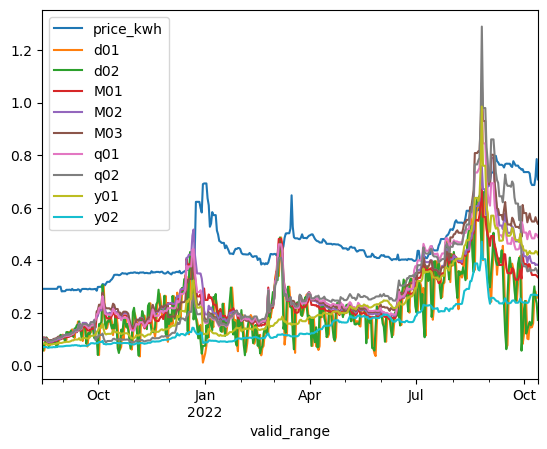

In [6]:
input.plot()

In [7]:
norm_layer = tf.keras.layers.Normalization(axis = 1)
norm_layer.adapt(input.to_numpy())
norm_input = norm_layer(input.to_numpy())
norm_input = pd.DataFrame(norm_input, columns = input.columns, index = input.index)

2023-01-26 09:00:10.168143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 09:00:10.222727: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
norm_input.head()

,price_kwh,d01,d02,M01,M02,M03,q01,q02,y01,y02
valid_range,,,,,,,,,,
2021-08-14,-1.240891,-1.274374,-1.266384,-1.422390,-1.283912,-1.068569,-1.163297,-0.937676,-1.018728,-1.090775
2021-08-15,-1.240891,-1.227868,-1.351801,-1.422390,-1.283912,-1.068569,-1.163297,-0.937676,-1.018728,-1.090775
2021-08-16,-1.240891,-1.311759,-1.145243,-1.422390,-1.283912,-1.068569,-1.163297,-0.937676,-1.018728,-1.090775
2021-08-17,-1.240891,-1.137157,-1.059240,-1.420035,-1.284412,-1.076052,-1.167313,-0.938407,-1.016769,-1.089021
2021-08-18,-1.240891,-1.030506,-0.931156,-1.436432,-1.296566,-1.079218,-1.175024,-0.941540,-1.021024,-1.089696


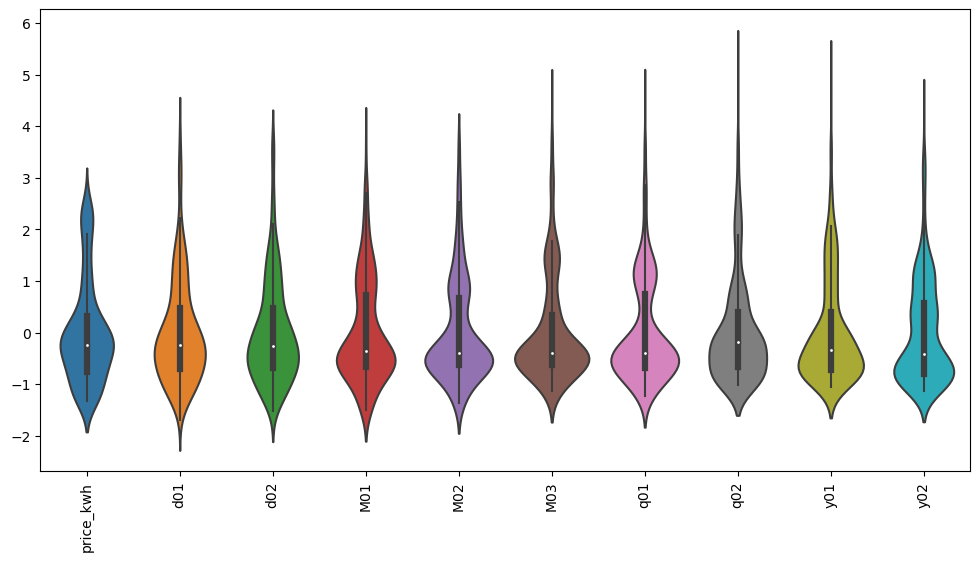

In [63]:
plt.figure(figsize=(12, 6))
ax = violinplot(data=norm_input)
_ = ax.set_xticklabels(input.keys(), rotation=90)

In [19]:
norm_input.shape

(426, 10)

In [71]:
n = len(input)
train_size = 0.6

train_df = norm_input[:int(train_size*n)]
val_df = norm_input[int(train_size*n):]

In [10]:
print(train_df.shape)
print(val_df.shape)

(383, 10)
(43, 10)


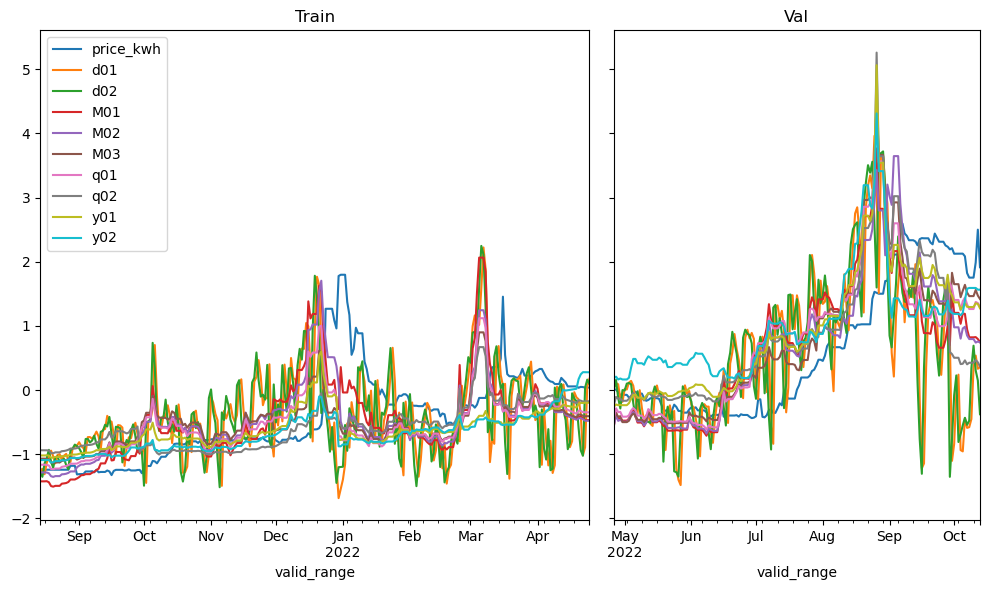

In [73]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,6), gridspec_kw={'width_ratios': [train_size, 1-train_size]}, sharey= "row")
ax1 = train_df.plot(ax = ax1)
ax2 = val_df.plot(ax = ax2, legend = False)
ax1.set_title("Train")
ax2.set_title("Val")
fig.tight_layout()

# Baseline

In [181]:
shift = 2
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=shift,
    label_columns=['price_kwh'], train_df=train_df, val_df=val_df)
single_step_window

Total window size: 3
Input indices: [0]
Label indices: [2]
Label column name(s): ['price_kwh']

In [182]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [183]:
baseline = Baseline(label_index=0)

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])

val_performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

6/6 [==============================] - 0s 5ms/step - loss: 0.0191 - mean_squared_error: 0.0191


# Linear Model

In [184]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, activation = None)
])

In [185]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 10)
Output shape: (32, 1, 1)


In [186]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    verbose = 1)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=early_stopping, verbose = 0)
  return history

In [187]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)

6/6 [==============================] - 0s 3ms/step - loss: 2.5728 - mean_squared_error: 2.5728


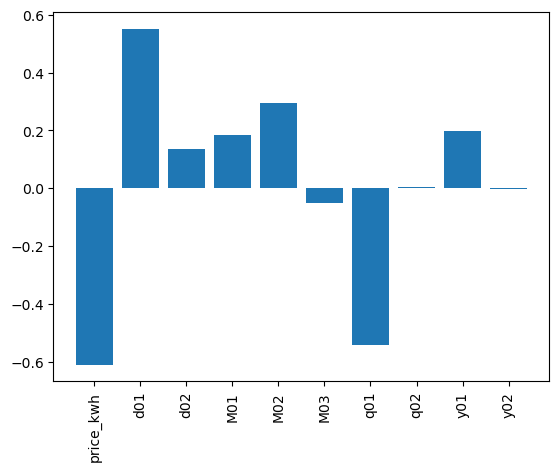

In [188]:
#Print weights of linear model
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [189]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)


6/6 [==============================] - 0s 4ms/step - loss: 0.2209 - mean_squared_error: 0.2209


# Multi Step Dense

In [190]:
CONV_WIDTH = 10
my_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=CONV_WIDTH,
    shift=shift,
    label_columns=['price_kwh'],
    train_df=train_df,
    val_df=val_df)

my_window

Total window size: 12
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 2  3  4  5  6  7  8  9 10 11]
Label column name(s): ['price_kwh']

In [191]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [192]:
print('Input shape:', my_window.example[0].shape)
print('Output shape:', multi_step_dense(my_window.example[0]).shape)


Input shape: (32, 10, 10)
Output shape: (32, 1, 1)


In [193]:
history = compile_and_fit(multi_step_dense, my_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(my_window.val)

Epoch 4: early stopping
5/5 [==============================] - 0s 10ms/step - loss: 1.1228 - mean_squared_error: 1.1228


# Convolutional Model

In [194]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [195]:
print("Conv model on `conv_window`")
print('Input shape:', my_window.example[0].shape)
print('Output shape:', conv_model(my_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 10, 10)
Output shape: (32, 1, 1)


In [196]:
history = compile_and_fit(conv_model, my_window)

val_performance['Conv'] = conv_model.evaluate(my_window.val)

5/5 [==============================] - 0s 7ms/step - loss: 1.2323 - mean_squared_error: 1.2323


# LSTM Model

In [197]:
CONV_WIDTH = 10
my_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=shift,
    label_columns=['price_kwh'],
    train_df=train_df,
    val_df=val_df)

my_window

Total window size: 12
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [11]
Label column name(s): ['price_kwh']

In [198]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [199]:
print('Input shape:', my_window.example[0].shape)
print('Output shape:', lstm_model(my_window.example[0]).shape)

Input shape: (32, 10, 10)
Output shape: (32, 1)


In [200]:
history = compile_and_fit(lstm_model, my_window)

val_performance['LSTM'] = lstm_model.evaluate(my_window.val)

Epoch 5: early stopping
5/5 [==============================] - 0s 9ms/step - loss: 2.1021 - mean_squared_error: 2.1021


#  LSTM + Dense

In [201]:
lstm_DNN_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(16),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [202]:
myhistory = compile_and_fit(lstm_DNN_model, my_window)

val_performance['LSTM+Dense'] = lstm_DNN_model.evaluate(my_window.val)

5/5 [==============================] - 0s 26ms/step - loss: 0.3863 - mean_squared_error: 0.3863


# Performance comparisson

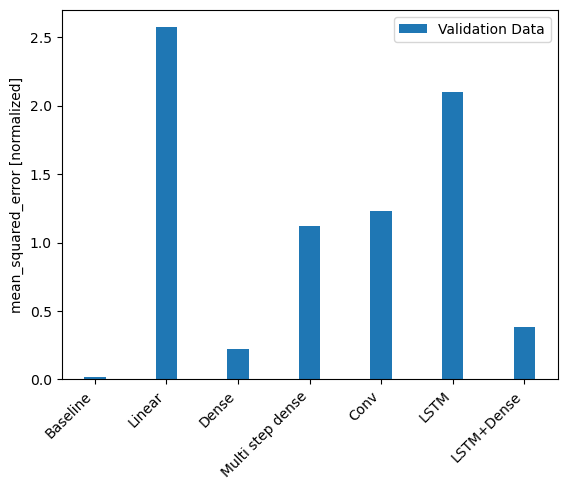

In [203]:
x = np.arange(len(val_performance))
width = 0.3
metric_name = 'mean_squared_error'
metric_index = lstm_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in val_performance.values()]

plt.ylabel('mean_squared_error [normalized]')
plt.bar(x, val_mae, width, label='Validation Data')
plt.xticks(ticks=x, labels=val_performance.keys(),
           rotation=45, ha = "right")
_ = plt.legend()


In [204]:
val_performance

{'Baseline': [0.019115770235657692, 0.019115770235657692],
 'Linear': [2.5728492736816406, 2.5728492736816406],
 'Dense': [0.22093166410923004, 0.22093166410923004],
 'Multi step dense': [1.1228306293487549, 1.1228306293487549],
 'Conv': [1.2322969436645508, 1.2322969436645508],
 'LSTM': [2.102138042449951, 2.102138042449951],
 'LSTM+Dense': [0.38632407784461975, 0.38632407784461975]}

In [205]:
lstm_model.metrics_names

['loss', 'mean_squared_error']

In [206]:
for name, value in val_performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


Baseline    : 0.0191
Linear      : 2.5728
Dense       : 0.2209
Multi step dense: 1.1228
Conv        : 1.2323
LSTM        : 2.1021
LSTM+Dense  : 0.3863


# Plot timeseries

In [207]:
def predict_with_date(self: tf.keras.Model, window: WindowGenerator, df) -> pd.DataFrame:
    model_input = window.make_dataset(df)
    predictions = self.predict(model_input, verbose = 0)
    dates = df.index[slice(window.total_window_size-1,None)]
    return pd.Series(predictions[:,predictions.shape[1]-1].flatten(), index = dates)

tf.keras.Model.predict_with_date = predict_with_date

def inverse_norm_price_p_kwh(df):
    sd = np.sqrt(norm_layer.variance[0,0])
    mean = norm_layer.mean[0,0]
    return df*sd + mean

def plot(self, window: WindowGenerator, df: pd.DataFrame):
    fig = plt.figure()
    plt.plot(
        inverse_norm_price_p_kwh(
            baseline.predict_with_date(window = window, df = df)), 
                                       label = "Baseline")
    
    plt.plot(
        inverse_norm_price_p_kwh(
        self.predict_with_date(window = window, df = df)), 
                                        label = "Predictions")
    
    plt.plot(
        inverse_norm_price_p_kwh(df["price_kwh"]), 
                                    label = "Original")
    
    plt.xticks(rotation = 45)
    plt.legend()

tf.keras.Model.plot = plot

In [208]:
window = my_window
plot_data = val_df

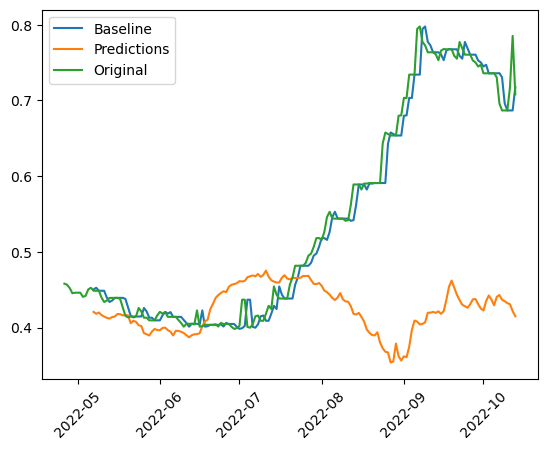

In [209]:
lstm_model.plot(window = window, df = val_df)

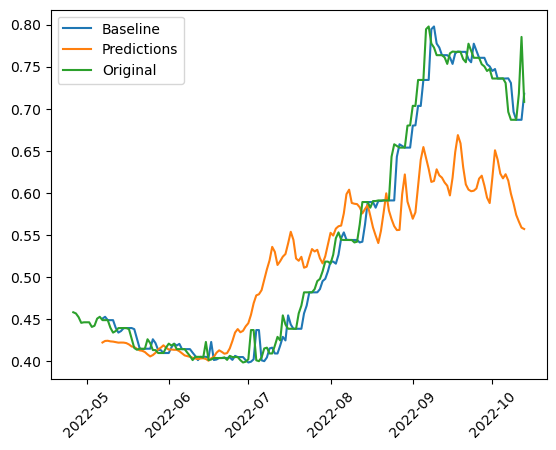

In [210]:
lstm_DNN_model.plot(window = window, df = val_df)

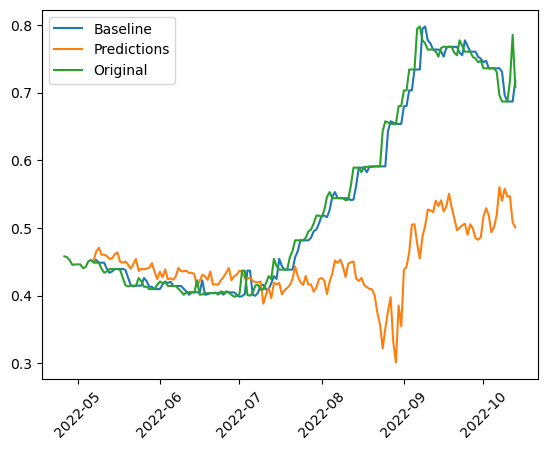

In [211]:
conv_model.plot(window, val_df)

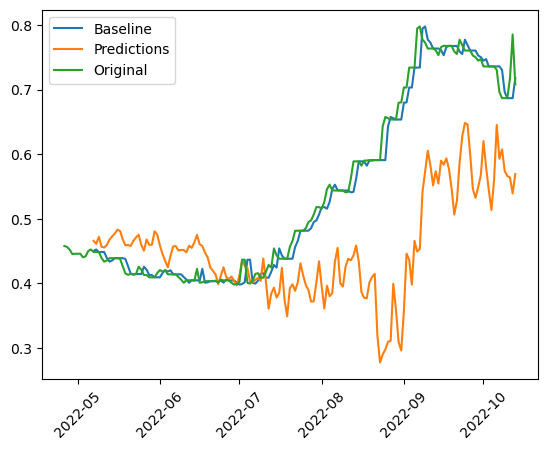

In [212]:
multi_step_dense.plot(window, val_df)

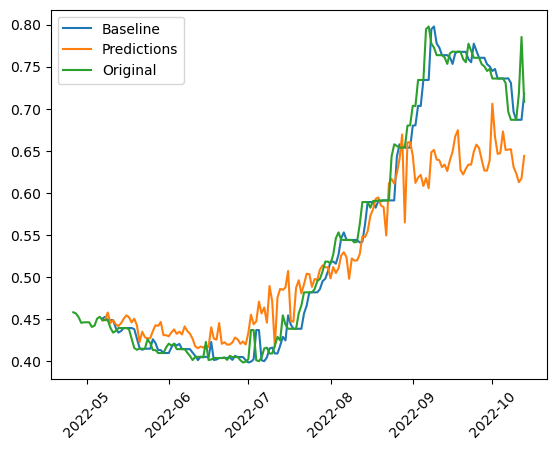

In [213]:
dense.plot(window, val_df)

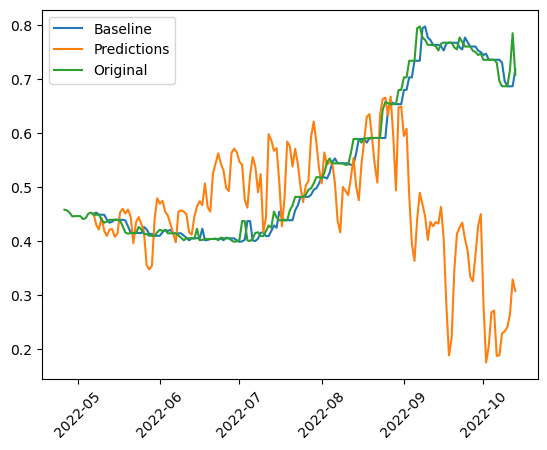

In [214]:
linear.plot(window, val_df)